# Data analysis

Here we will try some analysis on the data we have collected. We will try to find out the following things:

- Spatial Regression Analysis: 
We can perform spatial regression analysis to understand the relationships between tree distribution, ecological benefits, and environmental factors. This can help identify areas where planting specific tree species can have the most significant impact on reducing pollution or increasing oxygen levels.

Model documentation examples: 
- https://deepforest.readthedocs.io/en/latest/getting_started.html#sample-data
- https://github.com/kodujdlapolski/tree-research/blob/master/model.ipynb
- https://treeco.netlify.app

### OLS Regression:
- https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
OLS stands for Ordinary Least Squares, which is a method used to estimate the parameters of a linear regression model. In an OLS regression model, the goal is to find the line of best fit that minimizes the sum of the squared differences between the predicted values and the actual values of the dependent variable.

The OLS method works by calculating the slope and intercept of the line of best fit.

In [36]:
import pandas as pd
import pysal as ps
import statsmodels.api as sm
import geopandas as gpd
import libpysal as lp
from spreg import ML_Lag
from spreg import OLS
import numpy as np
from sklearn.metrics import mean_squared_error as mse

# Load the data 
#data = pd.read_csv('data_trees_modified.csv')
data = gpd.read_file('../data/geojson/geo_data_trees.geojson')

# take just the first 1000 rows
data = data.iloc[:1000]
# remove the last row of the data (summary)
#data = data.drop([len(data)-1])

data['Total Annual Benefits (eur/yr)'] = data['Total Annual Benefits (eur/yr)'].astype(float)
#data['Carbon Storage (kg)'] = data['Carbon Storage (kg)'].astype(float)
data['DBH (cm)'] = data['DBH (cm)'].astype(float)
# create a new column with the index of the name of the tree (so all the trees with the same name will have the same index)
data['Name_id'] = data['Name'].astype('category').cat.codes

# Select the dependent variable and independent variables
y = data['Total Annual Benefits (eur/yr)'] # dependent
X = data[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude']] # independent
#X = data[['Name_id']] # independent

# Create a spatial weights matrix
w = lp.weights.DistanceBand.from_dataframe(data, threshold=10, binary=True)

# Fit a spatial lag model
#model = sm.OLS(endog=y, exog=sm.add_constant(X), missing='drop')
#spatial_lag = ML_Lag(model.endog, model.exog, w=w, method='full', name_y=y.name, name_x=X.columns.tolist())
model = OLS(y.values.reshape(-1, 1), X.values, w=w, spat_diag=True)
print(model.summary)

# Print the regression results
#print(spatial_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        1000
Mean dependent var  :      4.1657                Number of Variables   :           5
S.D. dependent var  :      3.6748                Degrees of Freedom    :         995
R-squared           :      0.6304
Adjusted R-squared  :      0.6289
Sum squared residual:    4986.010                F-statistic           :    424.2763
Sigma-square        :       5.011                Prob(F-statistic)     :   2.78e-213
S.E. of regression  :       2.239                Log likelihood        :   -2222.257
Sigma-square ML     :       4.986                Akaike info criterion :    4454.513
S.E of regression ML:      2.2329                Schwarz criterion     :    4479.052

-----------------------------------------------------------------------------

Tutorial: 
- https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html

In [37]:
from pysal.model import spreg
from pysal.lib import weights
from scipy import stats
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import osmnx as ox
sns.set(style="whitegrid")

# Read OSM data - get administrative boundaries

# define the place query
query = {'city': 'Bologna'}

# get the boundaries of the place (add additional buffer around the query)
boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)

# Let's check the boundaries on a map
boundaries.explore()

/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_50537/518551908.py:17: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)


In [38]:
import geopandas as gpd
#import pysal
import libpysal as lp
from spreg import OLS
import numpy as np

# WE ARE WORKING WITH A SAMPLE OF THE DATA
# Load your tree dataset with coordinates and ecological benefits
trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')
# take a random sample of the dataset (5000 rows)
#trees = trees.sample(n=5000)

trees = trees.drop([len(trees)-1])

# Filter data geographically
trees_filtered = gpd.sjoin(trees, boundaries[["geometry"]])
trees_filtered = trees_filtered.reset_index(drop=True)

In [39]:
# change the total annual benefits to float
trees_filtered['Total Annual Benefits (eur/yr)'] = trees_filtered['Total Annual Benefits (eur/yr)'].str.replace(',', '.').astype(float)
# Here the tooltip parameter specifies which attributes are shown when hovering on top of the points
# The vmax parameter specifies the maximum value for the colormap (here, all 100 dollars and above are combined)
#trees_filtered.explore(column="Total Annual Benefits (eur/yr)", cmap="Reds", scheme="quantiles", k=4, tooltip=["Species Name", "Total Annual Benefits (eur/yr)"], vmax=30, tiles="CartoDB Positron") 

# Baseline (nonspatial) regression

Before introducing explicitly spatial methods, we will run a simple linear regression model. This will allow us, on the one hand, set the main principles of hedonic modeling and how to interpret the coefficients, which is good because the spatial models will build on this; and, on the other hand, it will provide a baseline model that we can use to evaluate how meaningful the spatial extensions are.

In [40]:
# explanatory_vars = ['crown_height', 'crown_width', 'dbh', 'age', 'Leaf Area (m2)']

trees_filtered["Total Annual Benefits (eur/yr)"] = trees_filtered["Total Annual Benefits (eur/yr)"].astype(float)
#trees_filtered['Carbon Storage (kg)'] = trees_filtered['Carbon Storage (kg)'].astype(float)
trees_filtered['DBH (cm)'] = trees_filtered['DBH (cm)'].astype(float)
trees_filtered["Height (m)"] = trees_filtered["Height (m)"].astype(float)
trees_filtered['Name_id'] = trees_filtered['Name'].astype('category').cat.codes
explanatory_vars = ['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']
#explanatory_vars = ['DBH (cm)', 'Name_id']

In [41]:
trees_filtered["log_benefit"] = np.log(trees_filtered["Total Annual Benefits (eur/yr)"] + 0.000001)

In [42]:
# let us build a spatial weights matrix that connects every observation to its 8 nearest neighbors. 
# This will allow us to get extra diagnostics from the baseline model.

w = weights.KNN.from_dataframe(trees_filtered, k=8)
w.transform = 'R'
w

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


In [43]:
m1 = spreg.OLS(trees_filtered[['log_benefit']].values, trees_filtered[explanatory_vars].values, 
                  name_y = 'log_benefit', name_x = explanatory_vars)

In [44]:
""" import matplotlib.pyplot as plt

coefs = m1.params
conf = m1.conf_int()
errors = conf[1] - coefs

plt.errorbar(coefs.index, coefs, yerr=[coefs - conf[0], conf[1] - coefs], fmt='o')
plt.title('Coefficients with Confidence Intervals')
plt.show() """

" import matplotlib.pyplot as plt\n\ncoefs = m1.params\nconf = m1.conf_int()\nerrors = conf[1] - coefs\n\nplt.errorbar(coefs.index, coefs, yerr=[coefs - conf[0], conf[1] - coefs], fmt='o')\nplt.title('Coefficients with Confidence Intervals')\nplt.show() "

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Moran's I: 0.37468144668961045
P-value: 0.001


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.37', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.37)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

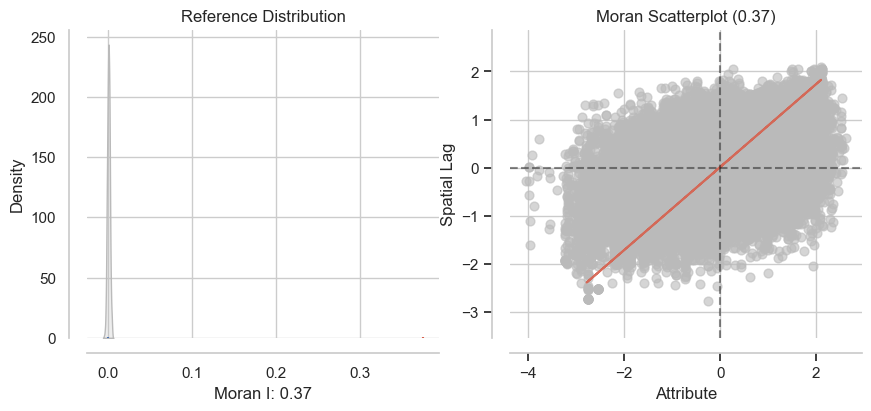

In [45]:
import libpysal as lp
from esda.moran import Moran
from splot.esda import plot_moran

# Assumendo che m2 sia il tuo modello OLS+W
residuals = m1.u

# Creazione di un oggetto weights come fatto per il modello
# Assicurati che i pesi siano basati sulla stessa struttura spaziale utilizzata nel modello
w = lp.weights.KNN.from_dataframe(trees_filtered, k=8)

# Calcolo del test di Moran's I per i residui
moran = Moran(residuals, w)
print("Moran's I:", moran.I)
print("P-value:", moran.p_sim)

# Opzionale: Visualizzare il grafico di Moran
plot_moran(moran)

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Assuming 'trees_filtered' is your DataFrame and has been appropriately pre-processed.

# Define the features and the target
X = trees_filtered[explanatory_vars].values
y = trees_filtered['log_benefit'].values

# Create a linear regression object
linear_regression_model = LinearRegression()

# Create a scorer for cross-validation based on mean squared error
mse_scorer = make_scorer(mean_squared_error)

# Perform 10-fold cross-validation
scores = cross_val_score(linear_regression_model, X, y, scoring=mse_scorer, cv=10)

# Calculate the mean and standard deviation of the cross-validation scores
mean_mse = np.mean(scores)
std_mse = np.std(scores)

print(f"Mean MSE from 10-fold cross-validation: {mean_mse}")
print(f"Standard Deviation of MSE from 10-fold cross-validation: {std_mse}")

Mean MSE from 10-fold cross-validation: 0.24143710105815303
Standard Deviation of MSE from 10-fold cross-validation: 0.03557500366829058


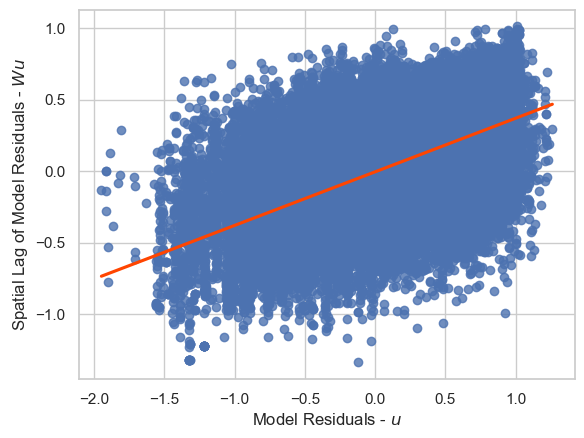

In [47]:
import seaborn

lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

In [48]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_benefit                Number of Observations:       84939
Mean dependent var  :      0.8118                Number of Variables   :           6
S.D. dependent var  :      1.1399                Degrees of Freedom    :       84933
R-squared           :      0.8219
Adjusted R-squared  :      0.8219
Sum squared residual:   19660.217                F-statistic           :  78372.1556
Sigma-square        :       0.231                Prob(F-statistic)     :           0
S.E. of regression  :       0.481                Log likelihood        :  -58376.063
Sigma-square ML     :       0.231                Akaike info criterion :  116764.127
S.E of regression ML:      0.4811                Schwarz criterion     :  116820.225

-----------------------------------------------------------------------------

In [49]:
import pysal as ps
from esda.moran import Moran
import numpy as np

# Assuming trees_filtered is your DataFrame and m1 is your OLS model from PySAL
# Calculate residuals from the OLS model
trees_filtered['residuals'] = m1.u

# You already created a spatial weights matrix 'w'
# Ensure it's row-standardized
w.transform = 'R'

# Compute Moran's I for the residuals
moran = Moran(trees_filtered['residuals'], w)

print(f"Moran's I: {moran.I}")
print(f"Expected Moran's I under null hypothesis of no spatial autocorrelation: {moran.EI}")
print(f"p-value: {moran.p_sim}")

# A significant Moran's I (low p-value) indicates spatial autocorrelation

Moran's I: 0.37468144668961045
Expected Moran's I under null hypothesis of no spatial autocorrelation: -1.1773293461112812e-05
p-value: 0.001


# Spatially lagged exogenous regressors (WX)

In [50]:
# Create weigts
w_benefit = weights.KNN.from_dataframe(trees_filtered, k=8)

# Assign spatial lag based on the pool values
lagged = trees_filtered.assign(w_benefit=weights.spatial_lag.lag_spatial(w_benefit, trees_filtered['Total Annual Benefits (eur/yr)'].values))

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


In [51]:
# Add pool to the explanatory variables
extended_vars = explanatory_vars + ["w_benefit"]

m2 = spreg.OLS(lagged[['Total Annual Benefits (eur/yr)']].values, lagged[extended_vars].values, 
               name_y = 'Total Annual Benefits (eur/yr)', name_x = extended_vars)

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Moran's I: 0.16011045655899137
P-value: 0.001


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.16', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.16)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

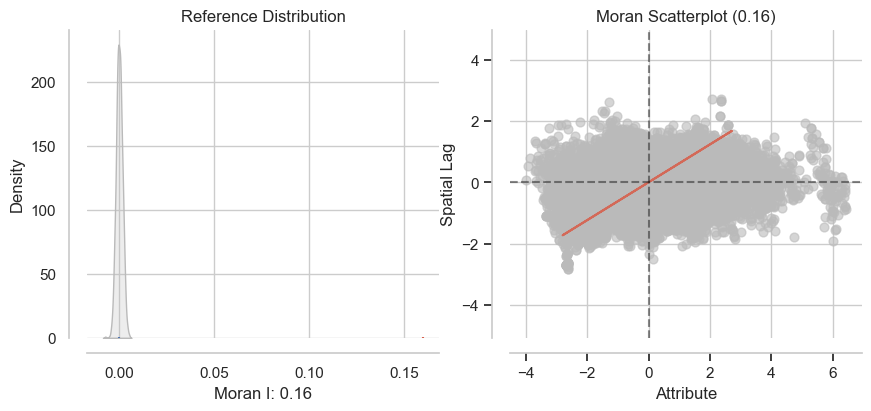

In [52]:
import libpysal as lp
from esda.moran import Moran
from splot.esda import plot_moran

# Assumendo che m2 sia il tuo modello OLS+W
residuals = m2.u

# Creazione di un oggetto weights come fatto per il modello
# Assicurati che i pesi siano basati sulla stessa struttura spaziale utilizzata nel modello
w = lp.weights.KNN.from_dataframe(trees_filtered, k=8)

# Calcolo del test di Moran's I per i residui
moran = Moran(residuals, w)
print("Moran's I:", moran.I)
print("P-value:", moran.p_sim)

# Opzionale: Visualizzare il grafico di Moran
plot_moran(moran)

In [53]:
import geopandas as gpd
import numpy as np
import libpysal as lp
from spreg import OLS



# New tree data
new_data = {'DBH (cm)': [80], 'Name_id': [1], 'Latitude': [44.11], 'Longitude': [11.23], 'Height (m)': [3]}

# Convert to DataFrame
new_data_df = pd.DataFrame(new_data)

# Merge new data with the existing dataset for spatial weights calculation
combined_data = trees_filtered.append(new_data_df, ignore_index=True)

# Recalculate weights with the new point
coords = combined_data[['Longitude', 'Latitude']]
w_combined = lp.weights.KNN.from_array(coords.values, k=8)
w_combined.transform = 'R'
combined_data['w_benefit'] = lp.weights.spatial_lag.lag_spatial(w_combined, combined_data['Total Annual Benefits (eur/yr)'])

# Extract the spatial lag value for the new data point
new_point_lag = combined_data['w_benefit'].iloc[-1]

# Prepare the input data for prediction, including the spatial lag
new_data_input = new_data_df.assign(w_benefit=new_point_lag)
X_new = new_data_input[extended_vars].values

# Add intercept term to input data for prediction
X_new_with_intercept = np.hstack((np.ones((X_new.shape[0], 1)), X_new))

# Use the coefficients from the model to predict
coefficients = m2.betas
predicted_benefit = np.dot(X_new_with_intercept, coefficients)

# Print the predicted 'Total Annual Benefits (eur/yr)'
print("Predicted Total Annual Benefits (eur/yr):", predicted_benefit[0])

/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_50537/1814079529.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [4.91634324]


In [54]:
import pandas as pd
import numpy as np
from spreg import OLS
import libpysal as lp

# Example: Creating a sample DataFrame
# Replace this with your actual data loading process
data = {
    'Height': [3.2, 4.1, 5.5, 3.8, 4.4],  # Example heights
    'Width': [2.1, 2.9, 3.5, 2.4, 3.2],   # Example widths
    'benefit': [10, 12, 15, 11, 13],        # Corresponding benefits
    'noise': [0.1, 0.2, 0.3, 0.4, 0.5]     # Example noise
}
df = pd.DataFrame(data)

# Assuming you have your DataFrame df with 'Height', 'Width', and 'benefit'

# Extract independent and dependent variables
X = df[['Height', 'Width']].values
y = df['benefit'].values

# Add a column of ones to X to account for the intercept
X_with_intercept = np.hstack((np.ones((X.shape[0], 1)), X))

# Fit the OLS model
model = OLS(y, X_with_intercept)

# Get the estimated coefficients (including intercept)
coefficients = model.betas

# Function to make predictions
def predict_ols(coefficients, X):
    # Add intercept term to input data
    X_with_intercept = np.hstack((np.ones((X.shape[0], 1)), X))
    # Multiply coefficients with input data and sum
    return np.dot(X_with_intercept, coefficients)

# Predict the 'benefit' for a new data point
new_data = np.array([[3, 4]])  # Height = 3, Width = 4
predicted_benefit = predict_ols(coefficients, new_data)

# Print the predicted 'benefit'
print("Predicted Benefit:", predicted_benefit[0])



Predicted Benefit: [11.66319921]


In [55]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Total Annual Benefits (eur/yr)                Number of Observations:       84939
Mean dependent var  :      3.7430                Number of Variables   :           7
S.D. dependent var  :      3.2826                Degrees of Freedom    :       84932
R-squared           :      0.7207
Adjusted R-squared  :      0.7207
Sum squared residual:  255593.446                F-statistic           :  36534.1437
Sigma-square        :       3.009                Prob(F-statistic)     :           0
S.E. of regression  :       1.735                Log likelihood        : -167309.946
Sigma-square ML     :       3.009                Akaike info criterion :  334633.891
S.E of regression ML:      1.7347                Schwarz criterion     :  334699.339

-----------------------------------------------------------

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Create a linear regression object
linear_regression = LinearRegression()

# Perform 10-fold cross-validation
cv_scores = cross_val_score(linear_regression, lagged[extended_vars].values, lagged['Total Annual Benefits (eur/yr)'].values, cv=10)

# Print the cross-validation scores
print(cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv = np.mean(cv_scores)
std_cv = np.std(cv_scores)

print(f"Mean CV Score: {mean_cv}")
print(f"Standard Deviation of CV Scores: {std_cv}")

[0.70962732 0.71686448 0.72523707 0.69563497 0.71015258 0.73589432
 0.7161298  0.69723029 0.57188616 0.77305701]
Mean CV Score: 0.7051714017554763
Standard Deviation of CV Scores: 0.04916851216137798


# Spatially lagged endogenous regressors (WY)

In [57]:
m3 = spreg.GM_Lag(trees_filtered[['Total Annual Benefits (eur/yr)']].values, trees_filtered[explanatory_vars].values, 
                  w=w, name_x = explanatory_vars)

In [58]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       84939
Mean dependent var  :      3.7430                Number of Variables   :           7
S.D. dependent var  :      3.2826                Degrees of Freedom    :       84932
Pseudo R-squared    :      0.6920
Spatial Pseudo R-squared:  0.6960

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -113.1574821      15.2566289      -7.4169387       0.0000000
            DBH (cm)       0.0949289       0.0002569     369.5449477       0.0000000
             Name_id       0.0004209       0.0000950       

In [69]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# take a sample of trees_filtered
tree_sample = trees_filtered.sample(n=5000)

g_y = tree_sample['Total Annual Benefits (eur/yr)'].values.reshape((-1,1))
g_X = tree_sample[explanatory_vars].values

g_coords = list(zip(tree_sample['Longitude'].values, tree_sample['Latitude'].values))

sel = Sel_BW(g_coords, g_y, g_X)
bw = sel.search()

gwr_model = GWR(g_coords, g_y, g_X, bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

# Print the coefficients for each location
for i, param in enumerate(gwr_results.params):
    print(f"Location {i}: Intercept: {param[0]}, Slopes: {param[1:]})")

Model type                                                         Gaussian
Number of observations:                                                5000
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          15435.844
Log-likelihood:                                                   -9912.829
AIC:                                                              19837.657
AICc:                                                             19839.680
BIC:                                                             -27099.019
R2:                                                                   0.709
Adj. R2:                                                              0.708

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

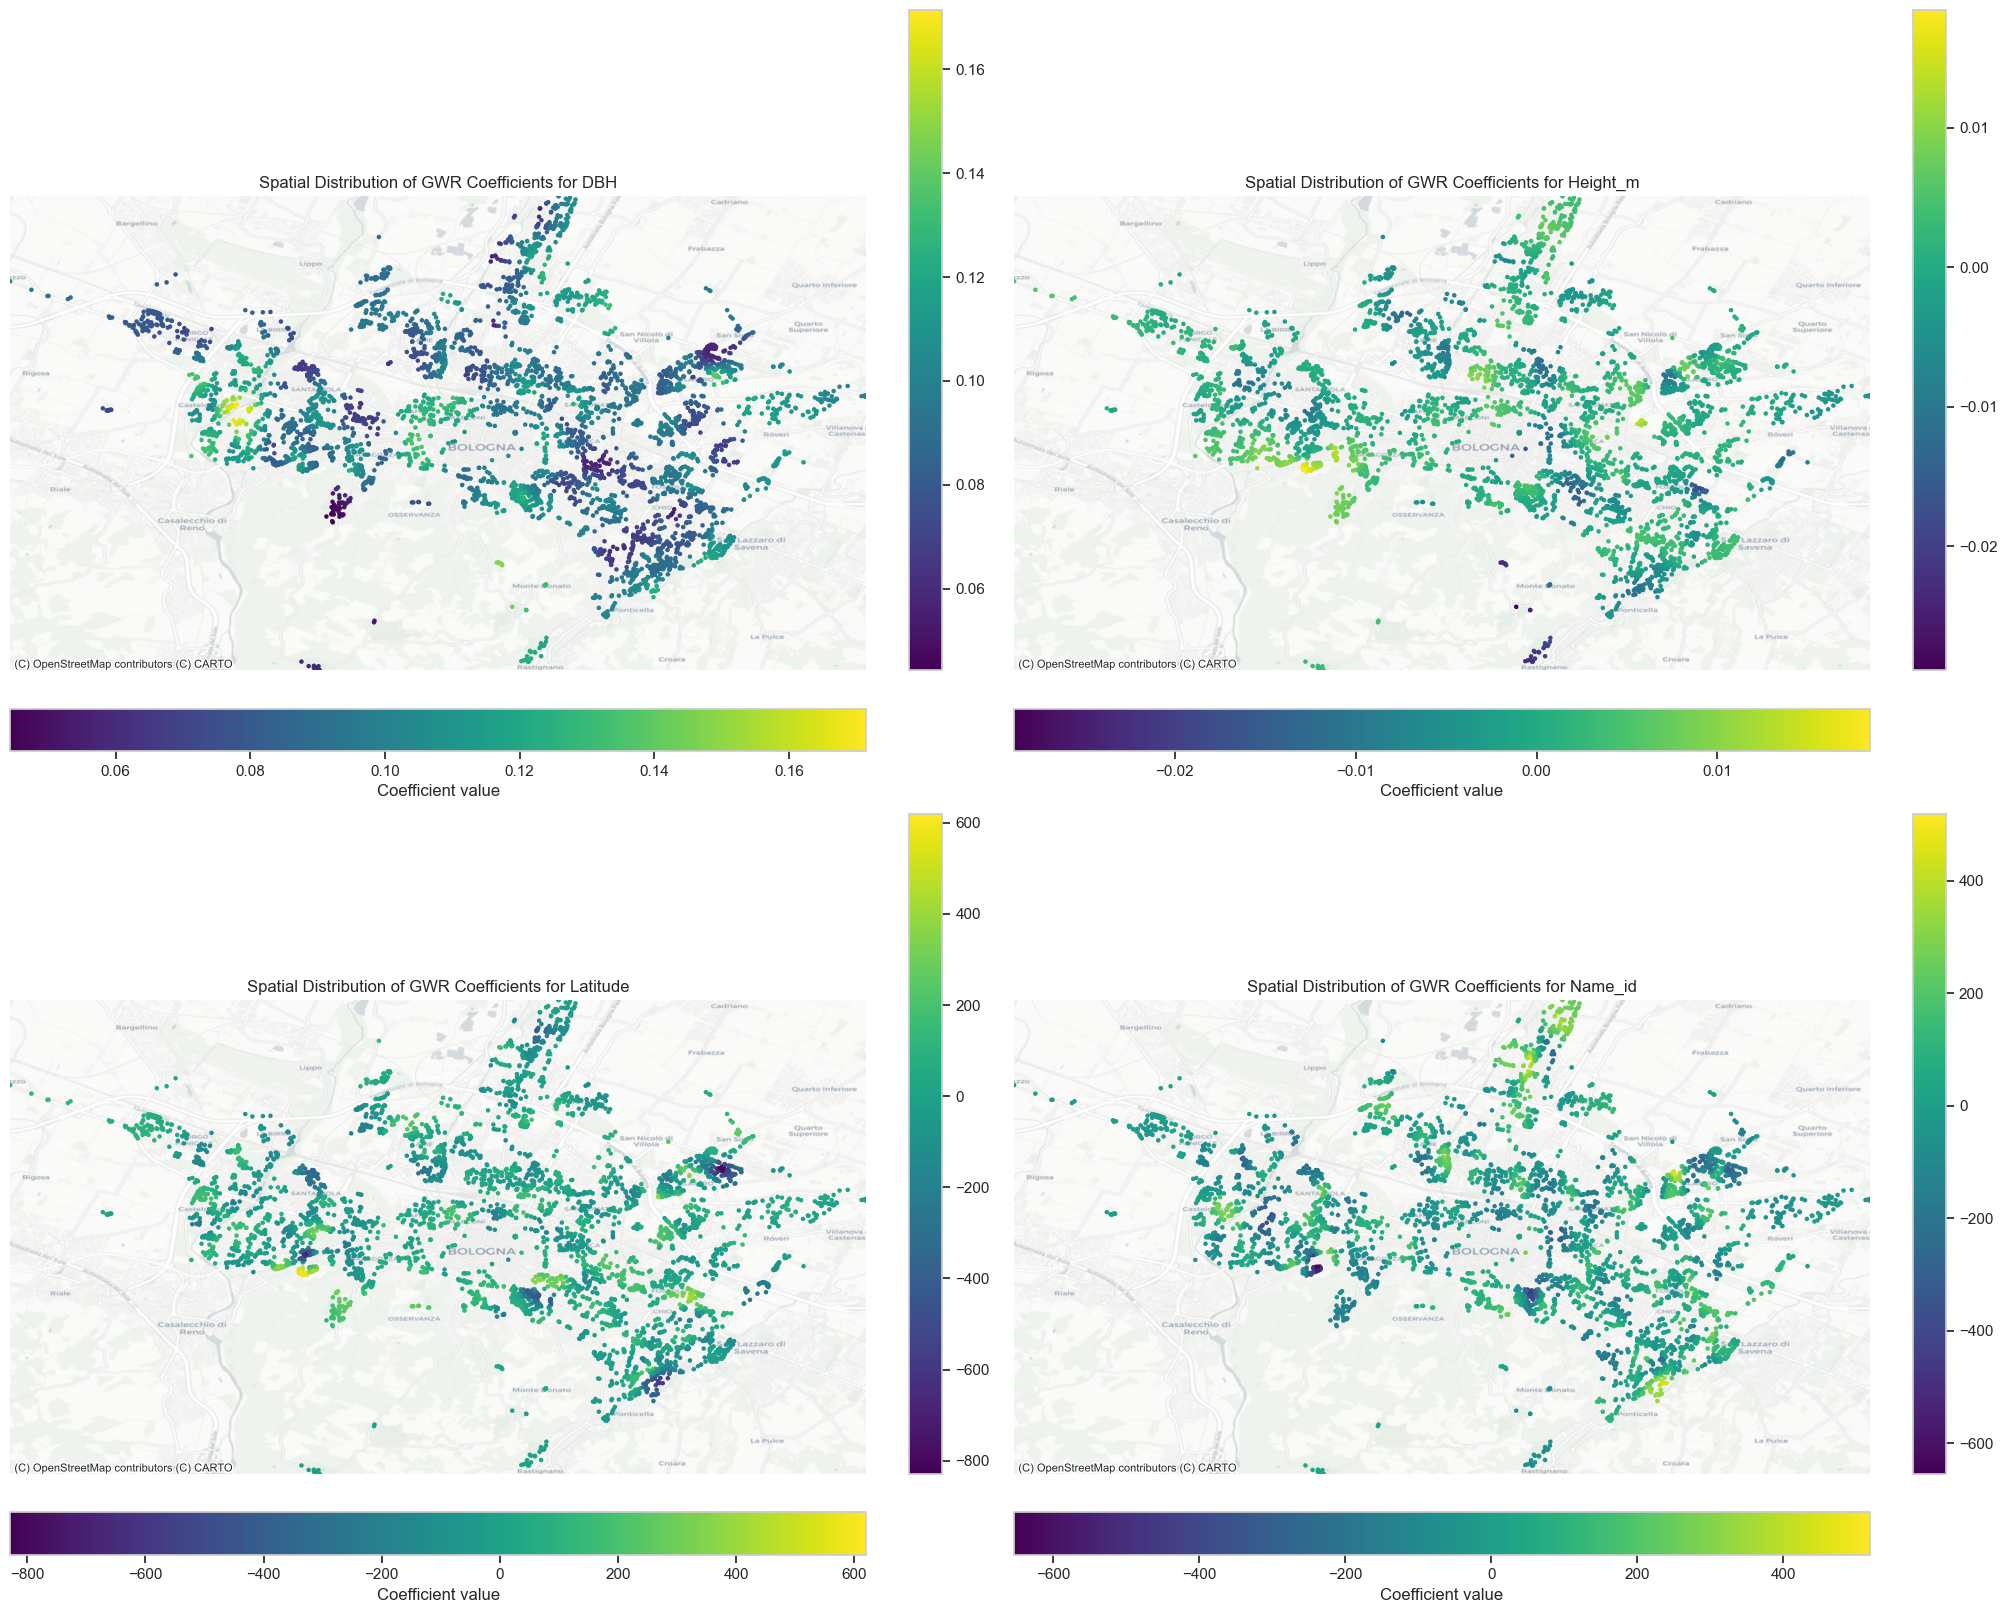

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert your sample data to a GeoDataFrame
gdf = gpd.GeoDataFrame(tree_sample, geometry=gpd.points_from_xy(tree_sample['Longitude'], tree_sample['Latitude']))

# Add the GWR results to the GeoDataFrame for the intercept and all slopes
variable_names = ['Intercept', 'DBH', 'Height_m', 'Latitude', 'Name_id']  # Add all your variable names here
for i, name in enumerate(variable_names):
    gdf[name] = gwr_results.params[:, i]

# Plotting
variables_to_plot = ['DBH', 'Height_m', 'Latitude', 'Name_id']  # The variables you want to plot

# Create a figure with subplots for each variable
fig, axs = plt.subplots(2, 2, figsize=(20, 16), constrained_layout=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, var in enumerate(variables_to_plot):
    # Plot each variable in a subplot
    gdf.plot(column=var, cmap='viridis', markersize=5, legend=True, ax=axs[i])
    
    # Add a basemap
    ctx.add_basemap(axs[i], crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    
    # Set axis limits to the sample data's bounding box
    axs[i].set_xlim(gdf.total_bounds[[0, 2]])
    axs[i].set_ylim(gdf.total_bounds[[1, 3]])
    
    # Remove axis clutter
    axs[i].set_axis_off()
    
    # Add a title to each subplot
    axs[i].set_title(f'Spatial Distribution of GWR Coefficients for {var}')
    
    # Add a colorbar
    fig.colorbar(axs[i].collections[0], ax=axs[i], orientation='horizontal', label='Coefficient value')

# Save the figure
plt.savefig('gwr_coefficients_maps.png', dpi=300)

# Show the plot
plt.show()

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Moran's I: 0.3012778105689905
P-value: 0.001


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.3', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.3)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

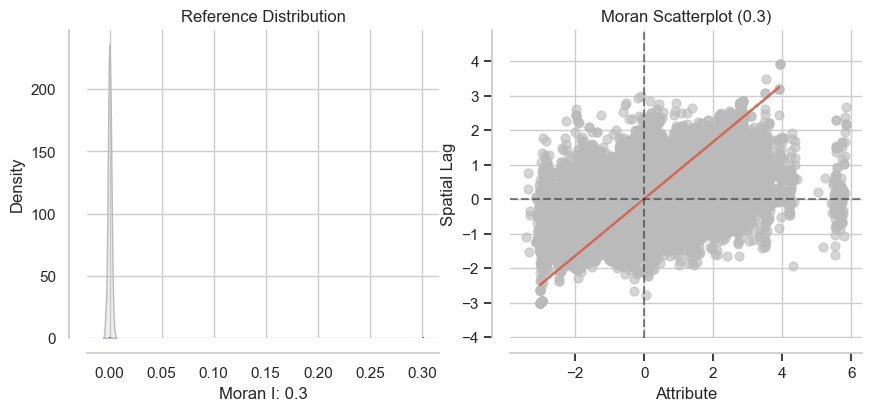

In [60]:
import libpysal as lp
from esda.moran import Moran
from splot.esda import plot_moran

# Assumendo che m2 sia il tuo modello OLS+W
residuals = m3.u

# Creazione di un oggetto weights come fatto per il modello
# Assicurati che i pesi siano basati sulla stessa struttura spaziale utilizzata nel modello
w = lp.weights.KNN.from_dataframe(trees_filtered, k=8)

# Calcolo del test di Moran's I per i residui
moran = Moran(residuals, w)
print("Moran's I:", moran.I)
print("P-value:", moran.p_sim)

# Opzionale: Visualizzare il grafico di Moran
plot_moran(moran)

# Prediction performance of spatial models

In [61]:
mses = pd.Series({'OLS': mse(trees_filtered["Total Annual Benefits (eur/yr)"], m1.predy.flatten()), \
                  'OLS+W': mse(trees_filtered["Total Annual Benefits (eur/yr)"], m2.predy.flatten()), \
                  'Lag': mse(trees_filtered["Total Annual Benefits (eur/yr)"], m3.predy_e)
                    })
mses.sort_values()

OLS+W     3.009141
Lag       3.275752
OLS      14.844203
dtype: float64

## Regression plots

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


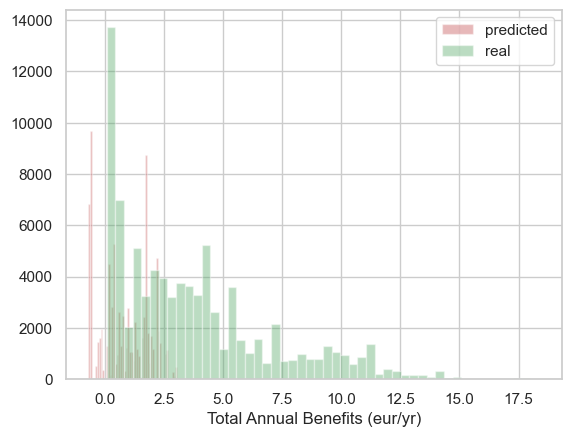

In [62]:
import matplotlib.pyplot as plt

reg_o3 = m1

# Plot the predicted vs actual values
sns.distplot(reg_o3.predy.flatten(), kde=False, bins=50, color='r', label='predicted')
sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
plt.legend()

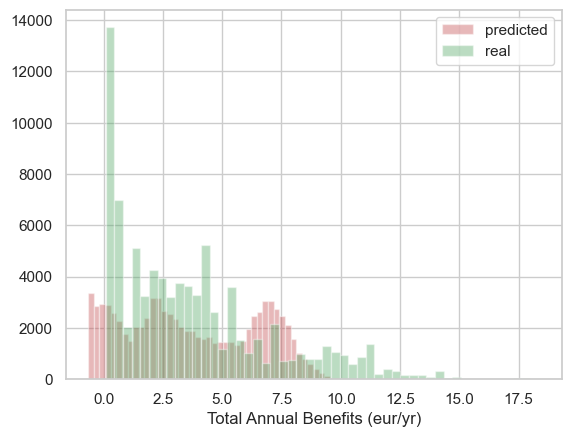

In [63]:
reg_o3 = m2

# Plot the predicted vs actual values
sns.distplot(reg_o3.predy.flatten(), kde=False, bins=50, color='r', label='predicted')
sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
plt.legend()

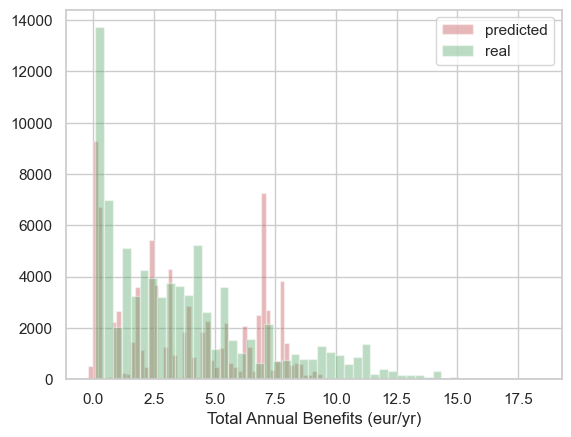

In [64]:
reg_o3 = m3

# Plot the predicted vs actual values
sns.distplot(reg_o3.predy.flatten(), kde=False, bins=50, color='r', label='predicted')
sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
plt.legend()

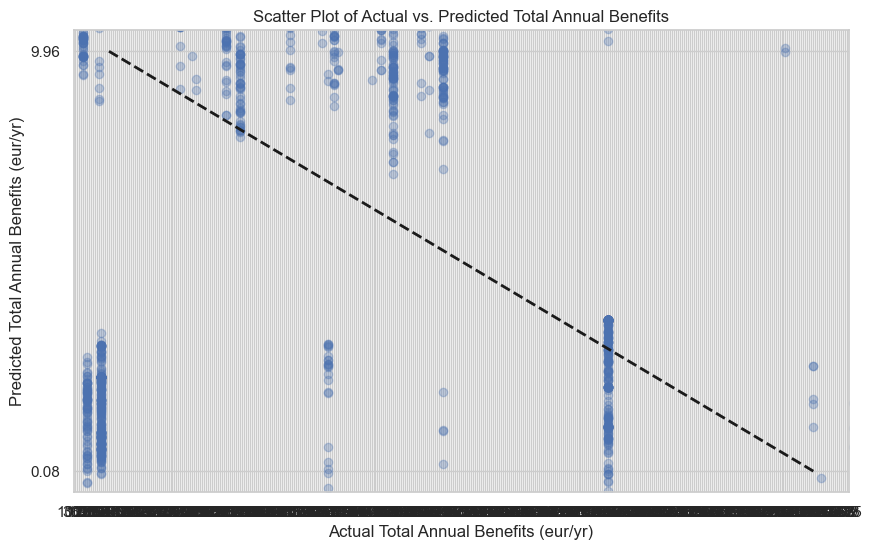

In [65]:
import matplotlib.pyplot as plt

# Assuming 'trees' is your dataframe and it contains a column 'Total Annual Benefits (eur/yr)' for actual values
# And assuming 'reg_o3' is your model object and 'reg_o3.predy' contains the predicted values

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(trees['Total Annual Benefits (eur/yr)'], reg_o3.predy.flatten(), alpha=0.3)
plt.title('Scatter Plot of Actual vs. Predicted Total Annual Benefits')
plt.xlabel('Actual Total Annual Benefits (eur/yr)')
plt.ylabel('Predicted Total Annual Benefits (eur/yr)')
plt.plot([trees['Total Annual Benefits (eur/yr)'].min(), trees['Total Annual Benefits (eur/yr)'].max()], 
         [trees['Total Annual Benefits (eur/yr)'].min(), trees['Total Annual Benefits (eur/yr)'].max()], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()


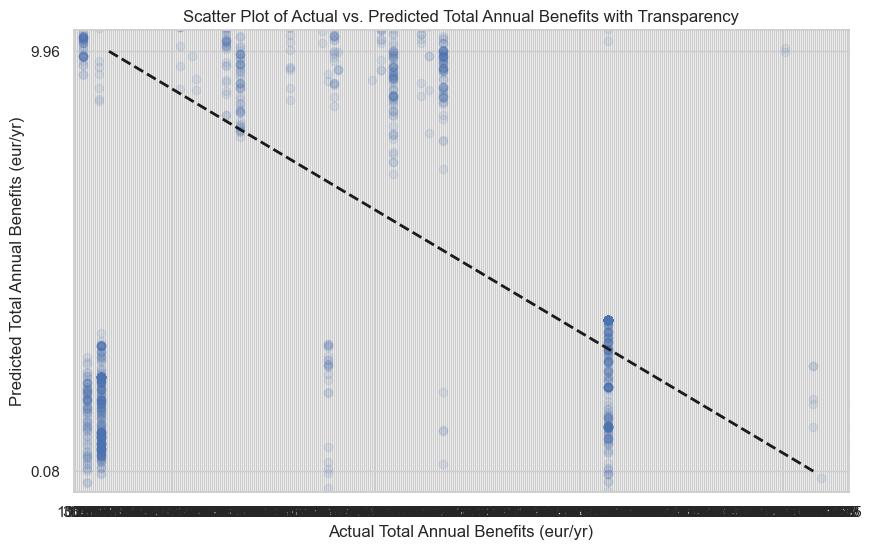

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace 'your_actual_data' and 'your_predicted_data' with your actual data arrays
actual_values = trees['Total Annual Benefits (eur/yr)']
predicted_values = reg_o3.predy.flatten()

# Scatter plot with transparency
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.1)  # Adjust alpha for transparency
plt.title('Scatter Plot of Actual vs. Predicted Total Annual Benefits with Transparency')
plt.xlabel('Actual Total Annual Benefits (eur/yr)')
plt.ylabel('Predicted Total Annual Benefits (eur/yr)')
plt.plot([np.min(actual_values), np.max(actual_values)], 
         [np.min(actual_values), np.max(actual_values)], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()

# # Hexbin plot
# plt.figure(figsize=(10, 6))
# plt.hexbin(actual_values, predicted_values, gridsize=50, cmap='Blues')
# plt.colorbar()
# plt.title('Hexbin Plot of Actual vs. Predicted Total Annual Benefits')
# plt.xlabel('Actual Total Annual Benefits (eur/yr)')
# plt.ylabel('Predicted Total Annual Benefits (eur/yr)')
# plt.plot([np.min(actual_values), np.max(actual_values)], 
#          [np.min(actual_values), np.max(actual_values)], 
#          'k--', lw=2)  # Diagonal line for reference
# plt.show()

# Residual plot
# residuals = actual_values - predicted_values
# plt.figure(figsize=(10, 6))
# plt.scatter(predicted_values, residuals, alpha=0.1)
# plt.title('Residual Plot of Predicted Total Annual Benefits')
# plt.xlabel('Predicted Total Annual Benefits (eur/yr)')
# plt.ylabel('Residuals (eur/yr)')
# plt.hlines(y=0, xmin=np.min(predicted_values), xmax=np.max(predicted_values), colors='k', linestyles='--', lw=2)
# plt.show()
